# Warmup for tensorflow

## Fibonacci numbers

In [68]:
import tensorflow as tf
import collections


def fibonacci_number(n_):
    """ calculates the fibonacci numbers with tf
         j = 1
         k = 0
         n = 10 # the searched fibonacci number
         for i in range(1, n):
             j = j + k
             k = j
         print('fibonacci number for ' + n + ' = ' j)
    """
    Pair = collections.namedtuple('Pair', 'j, k')
    ijk_0 = (tf.constant(1), Pair(tf.constant(1), tf.constant(0)))
    n = tf.placeholder(tf.int32)
    c = lambda i, p: i < n
    b = lambda i, p: (i + 1, Pair(p.j+ p.k, p.j))
    ijk_final = tf.while_loop(c, b, ijk_0)

    with tf.Session() as sess:
        result = sess.run(ijk_final, {n: n_})
        return result[1][0]


fib_n = []
for i in range(1, 15):
    fib_n.append(fibonacci_number(i))

print(fib_n)

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]


## Linear regression

final loss: 0.152
0.94 -0.14


[]

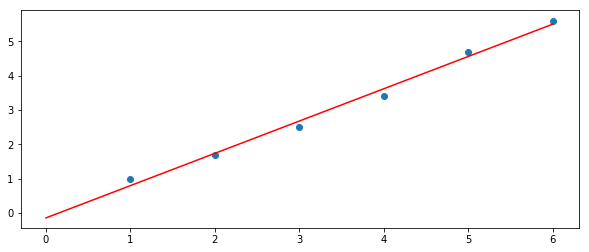

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

x_data = [1,   2,   3,   4,   5,   6]
y_data = [1, 1.7, 2.5, 3.4, 4.7, 5.6]

W = tf.Variable([1], dtype=tf.float32)
b = tf.Variable([1], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b

y = tf.placeholder(tf.float32)
loss = tf.reduce_sum(tf.square(linear_model - y))

init = tf.global_variables_initializer()

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(init)
    for i in range(1000):
        sess.run(train,{x:x_data, y:y_data})
    print('final loss: ' + str(sess.run(loss,{x:x_data, y:y_data})))
    b_ = sess.run(b)[0]
    W_ = sess.run(W)[0]
    print(W_, b_)

f = lambda x: W_ * x + b_
X = np.linspace(0, 6, 100)

fig = plt.figure(figsize=(10,4))
plt.scatter(x_data, y_data)
plt.plot(X, [f(_x_) for _x_ in X], color='red')
plt.plot()

## Softmax Regression Model



In [35]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# MODEL
y = tf.matmul(x,W) + b

# TRAINING
# CE with logits already applies the softmax 
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# EVALUATE
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for _ in range(1000):
        batch = mnist.train.next_batch(100)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    print(accuracy.eval(
        feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9192


## Multilayer Conv Net

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# reshape images so that they fit into the convnet
x_image = tf.reshape(x, [-1, 28, 28, 1])

# NETWORK STRUCTURE

# As we use ReLU initialize the weights randomly with slightly positive
# initial values to avaid dead neurons

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout (softmax regression)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# TRAINING
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
              x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.12
step 100, training accuracy 0.88
step 200, training accuracy 0.96
step 300, training accuracy 0.96
step 400, training accuracy 0.94
step 500, training accuracy 0.86
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.94
step 900, training accuracy 0.96
step 1000, training accuracy 0.94
step 1100, training accuracy 0.92
step 1200, training accuracy 0.94
step 1300, training accuracy 0.96
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.94
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 0.96
step 2400, 